<a href="https://colab.research.google.com/github/jmellafe/question_deduplication/blob/master/NLP_Project_version_hend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from collections import Counter
from nltk.corpus import stopwords

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import sklearn.svm as svm
from sklearn.metrics import roc_auc_score

In [10]:
# import data from the drive 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv' #change dir to your project folder


Mounted at /content/gdrive


# 0. Exploring the dataset




In [0]:
# Hend data importing cell 

df = pd.read_csv('/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv')
df.head()

In [0]:
#Alex data importing cell

df = pd.read_csv('/content/gdrive/My Drive/project/data/train.csv')


In [0]:
# Shuffle the data

df = df.sample(frac=1, random_state = 0).reset_index(drop=True)

# Create train, validation and test datasets
train_portion = 0.7
val_portion = 0.15
test_portion = 0.15

train_idx = int(train_portion * df.shape[0])
val_idx = int((train_portion + val_portion) * df.shape[0])

train = df[:train_idx]
val = df[train_idx:val_idx]
test = df[val_idx:]

In [0]:
is_dup = train['is_duplicate'].value_counts()
print("Class 0: ", is_dup[0], " Class1: ", is_dup[1])
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.title('Checking the balance of the classes')
plt.show()

In [0]:
# balancing the training set
class0 = train[train['is_duplicate']==0].sample(n=is_dup[1], random_state=1)
class1 = train[train['is_duplicate']==1]
train = pd.concat([class0, class1])


In [0]:

# HIstogram number of words

temp = train['question1'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp2 = train['question2'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp = pd.concat([temp, temp2]).dropna()

sns.distplot(temp, kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()


In [0]:
# detail same plot
sns.distplot(temp[temp < 50], kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()

# 1.Random Forest

see papers: http://papers.www2017.com.au.s3-website-ap-southeast-2.amazonaws.com/proceedings/p1221.pdf 


In [0]:
import nltk
nltk.download('punkt')

In [0]:
# simple tokenization just to build the tf-idf feature vector, probably we should replace it for something fancier
train['q1_tokens'] = train['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
train['q2_tokens'] = train['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)

In [0]:
dctr = Dictionary(train['q1_tokens'].dropna())
dctr.add_documents(train['q2_tokens'].dropna())

In [0]:
# preparing the features 

#series of all the questions in the training set 
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
print("Question: ",train_qs[1])

#length of the questions provided in the train set
len_qs_train = train_qs.apply(lambda x: len(x.split(' ')))
print("lengh of the question: ",len_qs_train[1])

qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
print("The pourcentage of questions including '?' : ",qmarks)

fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
print("The pourcentage of questions including '.' : ",fullstop)

capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
print("The pourcentage of questions starting with a capital letter is: ",capital_first)

capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
print("The pourcentage of questions including capital letters : ",capitals)

numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))
print("The mean max numbers of digits in  of questions including numbers : ",numbers)


In [0]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=1):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

stops = set(stopwords.words('english'))

In [0]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    
    return R


def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R
  
train_word_match = train.apply(word_match_share, axis=1, raw=True)

tfidf_train_word_match = train.apply(tfidf_word_match_share, axis=1, raw=True)


x_train = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_train['id'] = train['id']
x_train['is_duplicate'] = train['is_duplicate']

y_train = train['is_duplicate'].values




val_word_match = val.apply(word_match_share, axis=1, raw=True)
tfidf_val_word_match = val.apply(tfidf_word_match_share, axis=1, raw=True)
    


x_test = pd.DataFrame()
x_test['word_match'] = val_word_match
x_test['tfidf_word_match'] = tfidf_val_word_match

y_test = val['is_duplicate'].values

x_test['id'] = val['id']

predictors=['word_match','tfidf_word_match']
target='is_duplicate'


X_train= x_train[predictors]
y_train = x_train[target]
X_test=x_test[predictors]
#y_test = x_test[target]

#X=np.array(X).reshape(-1,1)
#y=np.array(y).reshape(-1,1)
#X= X.tolist()
#y= y.tolist()


def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal





clf= RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=100, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=1, random_state=1, verbose=0, warm_start=False, class_weight=None)
clf.fit(X_train,y_train)
##
accuracy=clf.score(X_test,y_test)
print("Random Forest",accuracy)
p=clf.predict_proba(X_test)

# 2. Siamese network 
https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18

## 2.1 Importing libraries and data

In [13]:
# importing libraries 

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

# File paths
TRAIN_CSV = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv'
TEST_CSV = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/test.csv'
EMBEDDING_FILE = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/Models/malstm_trained.h5'

# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
#test_df = pd.read_csv(TRAIN_CSV)
test_df = train_df[:1000]

stops = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Create embedding matrix

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) #delete special characters
    text = re.sub(r"what's", "what is ", text) # replace what's by what is
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [0]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)


In [0]:
# Build the model


# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 100 # prevously 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))



malstm_trained.save(MODEL_SAVING_DIR)  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 364290 samples, validate on 40000 samples
Epoch 1/25
 66900/364290 [====>.........................] - ETA: 30:04 - loss: 0.2033 - acc: 0.7034

In [0]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

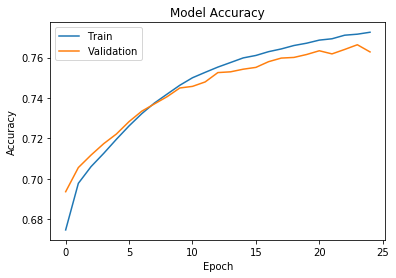

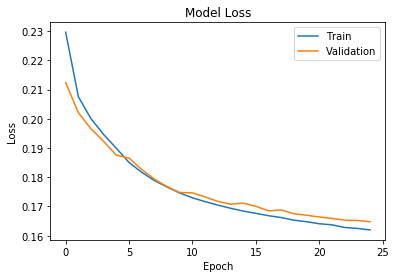

In [20]:
# Plotting the results


# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

